<a href="https://colab.research.google.com/github/azhara001/cs282hw9/blob/main/Copy_of_hw9_hand_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement Transformer from Scratch

In this coding homework, you will:

- Implement a simple transformer model from scratch to enhance your understanding of how it works.
- Create a hand-designed transformer model capable of solving a basic problem. This will help you comprehend the various operations that transformers can perform.
- Analyze the attention patterns of a trained network to gain insights into how learned models often utilize features that differ greatly from those employed by humans.

Please note that a GPU is not necessary for this task. If you're using Colab, you can select the "Runtime" -> "Change runtime type" menu and choose "None" as the hardware accelerator.

**Note:** The same variables will be defined in different ways in various subparts of the homework. If you encounter errors stating that a variable has the wrong shape or a function is missing an argument, ensure that you have re-run the cells in that particular problem subpart.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import time
import json
import inspect
import numpy as np
import torch
import torch.nn as nn
import math
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]  # Adjust this to make plots bigger or smaller

%load_ext autoreload
%autoreload 2

def _set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

TO_SAVE = {"time": time.time()}

## Implement a Simple Transformer

Below, you'll find a simple transformer implementation in Numpy that we have provided for you. It's important to note that this implementation is different from a Transformer in real applications. The differences include:

- Only a single layer with a single head is in the network.
- There are no residual connections.
- There is no normalization or dropout.
- We concatenate the positional encoding rather than adding it to the inputs.
- There are no activation functions or MLP layers.
- It does not support attention masking.
- The input is a single sequence instead of a batch. So there is no need to implement padding.

To ensure that you understand the transformer model fully, your task is to **implement a PyTorch equivalent model**. You don't need to include the printing and plotting code found in the Numpy version. **You should implement a vectorized version of the attention operation**, meaning that you should calculate all attention scores at once, rather than looping over keys. Once you have completed your implementation, make sure it passes the tests included in the cell below.

In [2]:
#@title Helper Functions

def rescale_and_plot(arr, title='', ax=None, x_lab=None, y_lab=None):
    """Rescale input array to be between 0 and 1, then plot it"""
    arr = (arr - arr.min())
    if arr.max() > 0:
        arr = arr / arr.max()
    ax.imshow(arr, cmap="Reds")
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if x_lab is not None:
        ax.set_xlabel(x_lab)
    if y_lab is not None:
        ax.set_ylabel(y_lab)


def train_loop(make_batch, input_dim, qk_dim, v_dim, pos_dim=None, max_seq_len=None, remove_cls=False, num_epochs=10001, lr=3e-2):
    transformer = PytorchTransformer(input_dim, qk_dim, v_dim, pos_dim, max_seq_len)
    optimizer = torch.optim.SGD(transformer.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for i in range(num_epochs):
        seq, target = make_batch()
        optimizer.zero_grad()
        out = transformer(seq)
        # If remove_cls is True, remove the first item of the sequence (the CLS token)
        if remove_cls:
            out = out[1:]
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(f'Step {i}: loss {loss.item()}')
    return transformer, loss.item()

def compare_transformers(hand_transformer, learned_transformer, seq):
    # Print the learned matrices
    # Rescale each weight matrix to be between 0 and 1, then plot them
    print('=' * 40, ' Hand Designed ', '=' * 40)
    out_hand = hand_transformer.forward(seq, verbose=False, plot=True)

    # Copy weights from the learned transformer to the hand transformer
    # so we can run the hand transformer's forward pass, with the plotting code
    py_Km = learned_transformer.Km.weight.T.detach().numpy()
    py_Qm = learned_transformer.Qm.weight.T.detach().numpy()
    py_Vm = learned_transformer.Vm.weight.T.detach().numpy()
    # positional encodings, if they exist
    if learned_transformer.pos is not None:
        py_pos = learned_transformer.pos.weight.detach().numpy()
    else:
        py_pos = None

    print('=' * 40, '   Learned   ', '=' * 40)
    np_learned_transformer = NumpyTransformer(py_Km, py_Qm, py_Vm, py_pos)
    out_learned = np_learned_transformer.forward(seq, verbose=False, plot=True)
    return out_hand, out_learned

# Test the numpy transformer and pytorch transformer to make sure they give the same results
def test():
    min_seq_len = 1
    max_seq_len = 4
    qk_dim = np.random.randint(1, 5)
    v_dim = np.random.randint(1, 5)
    in_dim = 5
    for i in range(10):
        # Randomly sample the matrices
        Km = np.random.randn(in_dim, qk_dim)
        Qm = np.random.randn(in_dim, qk_dim)
        Vm = np.random.randn(in_dim, v_dim)
        if i > 4:
            # Sometimes, don't use positional encodings
            pos = pos_dim = None
            seq_dim = in_dim
        else:
            pos_dim = np.random.randint(2, 4)
            pos = np.random.randn(max_seq_len, pos_dim)
            seq_dim = in_dim - pos_dim

        # Randomly sample the sequence
        seq = np.random.randn(np.random.randint(min_seq_len, max_seq_len + 1), seq_dim)
        # Get the numpy transformer output
        out_np = NumpyTransformer(Km, Qm, Vm, pos).forward(seq, verbose=False)
        # Create a pytorch transformer and fill the weights with the numpy matrices
        transformer = PytorchTransformer(seq_dim, qk_dim, v_dim, pos_dim, max_seq_len)
        state_dict = transformer.state_dict()
        # Replace the weights with the numpy matrices
        state_dict['Km.weight'] = torch.FloatTensor(Km.T)
        state_dict['Qm.weight'] = torch.FloatTensor(Qm.T)
        state_dict['Vm.weight'] = torch.FloatTensor(Vm.T)
        if pos is not None:
            state_dict['pos.weight'] = torch.FloatTensor(pos)
        transformer.load_state_dict(state_dict)
        # Get the pytorch transformer output
        out_py = transformer(torch.FloatTensor(seq)).detach().numpy()

        # Compare the outputs
        if not np.allclose(out_np, out_py, rtol=1e-3):
            print('ERROR!!')
            print('Numpy output', out_np)
            print('Pytorch output', out_py)
            print('Difference', out_np - out_py)
            raise ValueError('Numpy and Pytorch outputs do not match')
    print('All done!')
    _set_seed(1998)
    transformer = PytorchTransformer(7, 4, 3, 2, 9)
    o = transformer(torch.randn(8, 7))
    TO_SAVE["torch_transformer_shape"] = list(o.shape)
    TO_SAVE["torch_transformer_value"] = o.view(-1).tolist()[2:7]
    TO_SAVE["torch_transformer_init"] = inspect.getsource(PytorchTransformer.__init__)
    TO_SAVE["torch_transformer_forward"] = inspect.getsource(PytorchTransformer.forward)

Implement the `PytorchTransformer` class. It should be identical to the forward pass of the `NumpyTransformer` class.

**Hint:** The attention operation should be implemented as:

$$\mathrm{softmax}(\dfrac{QK^T}{ \sqrt{d_k}}) \cdot V$$

where the softmax is applied to the last dimension, meaning that the softmax is applied independently to each query's scores.

In [3]:
#@title Numpy Transformer and PyTorch Transformer

class NumpyTransformer:
    def __init__(self, Km, Qm, Vm, pos=None):
        """
        # Km, Qm, Vm are the matrices that will be used to compute the attention
        # Km and Qm are size (input_dim + pos_dim, qk_dim), and Vm is (input_dim + pos_dim, v_dim).
        # pos is an array of positional encodings of shape (max_seq_len, pos_dim) that will be concatenated to the input sequence
        """
        self.Km = Km
        self.Qm = Qm
        self.Vm = Vm
        self.pos = pos
        self.qk_dim = Qm.shape[1]

    def forward(self, seq, verbose=False, plot=False):
        # seq is a numpy array of shape (seq_len, input_dim). There is no batch dimension.

        # Concatenate positional encodings if they are provided
        if self.pos is not None:
            seq = np.concatenate([seq, self.pos[:seq.shape[0]]], axis=-1)
        K = seq @ self.Km # seq_len x qk_dim
        Q = seq @ self.Qm # seq_len x qk_dim
        V = seq @ self.Vm # seq_len x v_dim
        if verbose:
            print('Keys', K.tolist())
            print('Queries', Q.tolist())
            print('Values', V.tolist())
        if plot:
            fig, axs = plt.subplots(nrows=1,ncols=8)
            fig.tight_layout()
            rescale_and_plot(self.Km.T, 'Km', axs[0], x_lab='d_i', y_lab='d_qk')
            rescale_and_plot(self.Qm.T, 'Qm', axs[1], x_lab='d_i', y_lab='d_qk')
            rescale_and_plot(self.Vm.T, 'Vm', axs[2], x_lab='d_i', y_lab='d_v')

            rescale_and_plot(K.T, 'K', axs[3], x_lab='seq', y_lab='d_qk')
            rescale_and_plot(Q.T, 'Q', axs[4], x_lab='seq', y_lab='d_qk')
            rescale_and_plot(V.T, 'V', axs[5], x_lab='seq', y_lab='d_v')

        outputs = []
        attn_weights = []
        # Compute attention
        for i, q in enumerate(Q):
            if verbose: print(f'Item {i}: Computing attention for query {q}')
            dot = K @ q
            if verbose: print('  Dot products between the query and each key:', dot)
            # Divide by sqrt(qk_dim)
            dot = dot / np.sqrt(self.qk_dim)
            # Softmax function
            softmax_dot = np.exp(dot) / np.sum(np.exp(dot), axis=-1, keepdims=True)
            if verbose: print('  Weighting score for each value:', softmax_dot)
            attn_weights.append(softmax_dot)
            out_i = softmax_dot @ V
            if verbose: print('  New sequence item', out_i)
            outputs.append(out_i)
        if plot:
            rescale_and_plot(np.array(attn_weights).T, 'Attn', axs[6], x_lab='Q', y_lab='K')
            rescale_and_plot(np.array(outputs).T, 'Out', axs[7], x_lab='seq', y_lab='d_v')
            plt.show()
        # Return the output sequence (seq_len, output_dim)
        return np.array(outputs)

class PytorchTransformer(nn.Module):
    def __init__(self, input_dim, qk_dim, v_dim, pos_dim=None, max_seq_len=10):
        super().__init__()
        if pos_dim is not None:
            self.pos = nn.Embedding(max_seq_len, pos_dim)
        else:
            self.pos = None
        in_dim = input_dim
        if pos_dim is not None:
            in_dim += pos_dim

        ########################################################################
        # TODO: Define query, key, value projection layers Qm, Km, Vm.
        #       Each of them is a linear projection without bias
        ########################################################################
        self.Qm = nn.Linear(in_features=in_dim,out_features=qk_dim,bias=False)
        self.Km = nn.Linear(in_features=in_dim,out_features=qk_dim,bias=False)
        self.Vm = nn.Linear(in_features=in_dim,out_features=v_dim,bias=False)

        ########################################################################

        self.d_k = qk_dim

    def forward(self, seq):
        """
        Transformer forward pass

        Inputs: seq is a torch tensor of shape (seq_len, input_dim).
        Outputs: a torch tensor of shape (seq_len, v_dim), the output of the attention operation
        """
        ################################################################################################
        # TODO: Implement the forward pass of the `PytorchTransformer` class.
        #       The forward pass should be identical to the forward pass of the
        #       `NumpyTransformer` class.
        #
        # Hint: The attention operation should be implemented as
        #       If `pos` exists, it should be concatenated to the input sequence.
        #################################################################################################
        if self.pos is not None:

          seq = torch.concat((seq,self.pos.weight[:seq.shape[0]]),axis=-1)

        Q , K , V = self.Qm(seq), self.Km(seq), self.Vm(seq)

        dot = Q@K.T

        dot_scaled = dot/np.sqrt(self.d_k)
        soft_max_dot = nn.functional.softmax(dot_scaled,dim=1)
        out = soft_max_dot@V
        ################################################################################################
        # END OF YOUR CODE
        ################################################################################################
        return out

test()

All done!


## Self-Attention: Attention by Content

In this coding homework, we will explore how Transformers can attend to different tokens in a variable-length sequence based on their contents. We will do this by **implementing a Transformer that performs the *identity* operation on a sequence of one-hot vectors**. We will then compare the performance and weights of this hand-coded Transformer with those of a PyTorch model trained on the same task.

To hand-design the Transformer, we will **choose values for `Km`, `Qm`, and `Vm` that enable the model to attend to the content of each token in the input sequence**. We will then use this Transformer to process several example data points, and verify that the output matches the input.

Once your hand-written Transformer is working correctly, we will run the PyTorch training loop to train a model on the identity operation task. We will then compare the weights and intermediate outputs of this model with those of our hand-coded transformer, and comment on their similarities and differences. Note that when we generate plots, we will rescale the range of the weights and outputs to 0-1, so we can compare their relative values without comparing absolute values.

The test cases for our hand-coded transformer are as follows:

```
Input sequence -->   Output sequence
[A, B, C, C]   -->   [A, B, C, C]
[C, A, C]      -->   [C, A, C]
[B, B, C]      -->   [B, B, C]
```

We have provided some hints below, but to enhance your understanding of attention and the Transformer, we highly recommend attempting this problem to the best of your abilities before referring to the hints.

In [4]:
#@title Hints

# Hint 1: To attend to a specific element, ensure that its pre-softmax score is
#         significantly higher than that of the other elements.
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
print('='*20, 'Hint 1', '='*20)
print('Selecting index 0', softmax(np.array([9, 0, 0])))
print('Selecting index 1', softmax(np.array([-3, 5, -5])))


# Hint 2: Attending to a particular element is more manageable if the keys are
#         orthogonal.
print('='*20, 'Hint 2', '='*20)
keys = np.array([[2, 0], [0, 1]])  # Orthogonal
q = np.array([5, 0])
print('Selecting index 0', softmax(q @ keys))
q = np.array([0, 5])
print('Selecting index 1', softmax(q @ keys))


# Hint 3: You can use the following helper functions to test the keys, queries,
#         and values produced by your matrix for each valid sequence element.
#  Km, Qm, Vm, and are the matrices you will define below.
all_token_seq = np.eye(3)  # Each row is a sequence element. The identity corresponds to [A, B, C].
get_K = lambda: all_token_seq @ Km  # Each row of the output is a key
get_Q = lambda: all_token_seq @ Qm  # Each row of the output is a query
get_V = lambda: all_token_seq @ Vm  # Each row of the output is a value


# Hint 4: To test different attention weights, use the softmax function defined
#         above.


# Hint 5: When there are repeated elements in a sequence with the same content,
#         attending to all of them rather than a single one will be simpler.
#         Since they have the same content, taking a "weighted average" over
#         values weighted by attention scores will produce the same output as
#         attending to a single one.

==================== Hint 1 ====================
Selecting index 0 [9.99753241e-01 1.23379352e-04 1.23379352e-04]
Selecting index 1 [3.35334911e-04 9.99619282e-01 4.53826452e-05]
==================== Hint 2 ====================
Selecting index 0 [9.99954602e-01 4.53978687e-05]
Selecting index 1 [0.00669285 0.99330715]


In [5]:
# The definition of tokens
A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])
tokens = [A, B, C]

print(tokens)

################################################################################
# TODO: Write Numpy arrays for `Km`, `Qm`, and `Vm`.
#       The dimensions should be (input_dim, qk_dim), (input_dim, qk_dim), and
#       (input_dim, v_dim), respectively.
#       In this case, input_dim = 3, and v_dim = 3. qk_dim can be any value you
#       choose, but 3 is a reasonable choice.
################################################################################
Km = np.identity((3))
Qm = np.array([[100,0,0],[0,100,0],[0,0,100]])
Vm = np.identity((3))
############################################ END OF YOUR CODE ##################

def generate_test_cases_identity(tokens, max_len=7):
    """
    Generate a random sequence consisting of tokens for testing
    """
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    expected_out = input_arr
    return input_arr, expected_out

# Test your implementation
show_attention = False  # Set this to True for debugging
for i in range(10):
    seq, expected_out = generate_test_cases_identity(tokens)
    np_transformer = NumpyTransformer(Km, Qm, Vm)
    out = np_transformer.forward(seq, verbose=show_attention)
    if not np.allclose(out, expected_out, rtol=1e-3):
        print(f'FAIL: {seq} -> {out} != {expected_out}')

_set_seed(1997)
seq, _ = generate_test_cases_identity(tokens)
np_transformer = NumpyTransformer(Km, Qm, Vm)
out = np_transformer.forward(seq, verbose=False)
TO_SAVE["attention_by_content"] = out.reshape(-1).tolist()
TO_SAVE["attention_by_content_Q"] = Qm.reshape(-1).tolist()
TO_SAVE["attention_by_content_K"] = Km.reshape(-1).tolist()
TO_SAVE["attention_by_content_V"] = Vm.reshape(-1).tolist()

[array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1])]


Step 0: loss 0.4911634922027588
Step 1000: loss 0.0009149469551630318
Step 2000: loss 0.008881769143044949
Step 3000: loss 0.01725190319120884
Step 4000: loss 0.009867138229310513
Step 5000: loss 0.004985815845429897
Step 6000: loss 0.0006846142350696027
Step 7000: loss 0.001099123852327466
Step 8000: loss 0.002010955708101392
Step 9000: loss 0.001820888603106141
Step 10000: loss 0.0004175232897978276
seq: [[1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]]
========================================  Hand Designed  ========================================


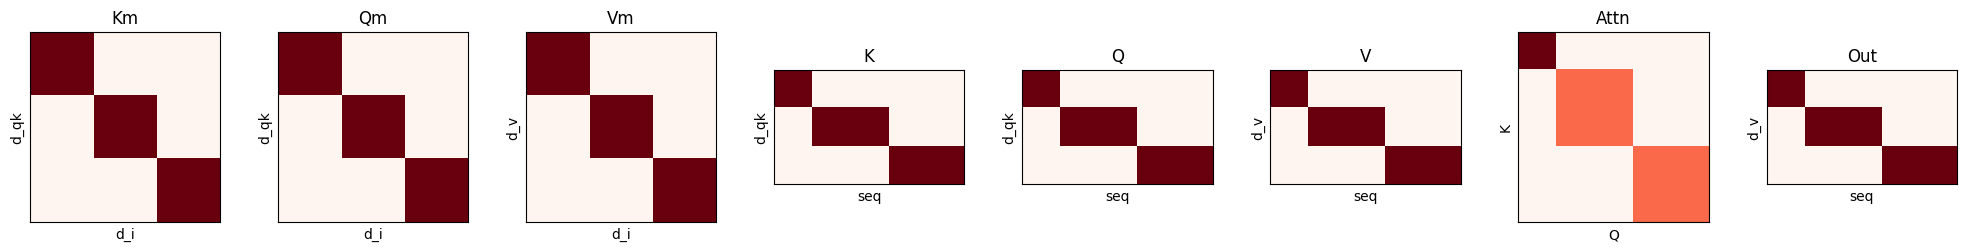

========================================    Learned    ========================================


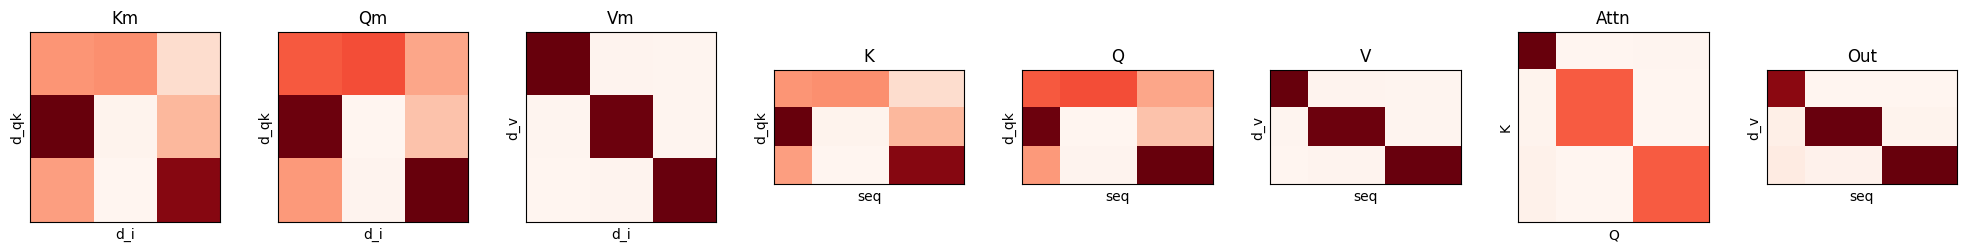

(array([[1.00000000e+00, 1.68665552e-25, 1.68665552e-25],
        [4.21663880e-26, 1.00000000e+00, 8.43327760e-26],
        [4.21663880e-26, 1.00000000e+00, 8.43327760e-26],
        [4.21663880e-26, 8.43327760e-26, 1.00000000e+00],
        [4.21663880e-26, 8.43327760e-26, 1.00000000e+00]]),
 array([[9.07054924e-01, 3.71411799e-02, 5.58034481e-02],
        [1.77222980e-03, 9.76905289e-01, 2.13222332e-02],
        [1.77222980e-03, 9.76905289e-01, 2.13222332e-02],
        [8.03523652e-04, 1.59401374e-02, 9.83256416e-01],
        [8.03523652e-04, 1.59401374e-02, 9.83256416e-01]]))

In [6]:
# Compare the hand-designed and trained transformers
def make_batch_identity(tokens=tokens, max_len=7):
    seq, target = generate_test_cases_identity(tokens, max_len=max_len)
    return torch.FloatTensor(seq), torch.FloatTensor(target)

_set_seed(227)

A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])
transformer_py, loss = train_loop(make_batch_identity, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1])
seq = np.stack([A, B, B, C, C])
print("seq:", seq)
compare_transformers(np_transformer, transformer_py, seq)  # If the plots don't print correctly, re-run this cell

### Question

In the figure provided, compare the variables of your hand-designed Transformer with those of the learned Transformer. **Identify the similarities and differences between the two sets of variables and provide a brief explanation for each difference**.

## Self-Attention: Attention by Position

In Transformers, tokens can decide what other tokens to attend to by looking at their positions. In this section, we'll explore how this works by **hand-designing a Transformer for the task of copying the first token of a sequence across the entire sequence.**

To accomplish this, we'll add a positional encoding to the input sequence. Transformers typically use a sinusoidal positional encoding or a learned positional encoding, but we'll **set the weight by hand to any value we choose**. These positional encodings will get concatenated to the input sequence inside the Transformer. For simplicity, we'll *concatenate* the positional encoding to the input embeddings instead of adding it.

Here are the example data points (where `A`, `B`, and `C` are vectors and `A:pos_0` represents the concatenation between vectors `A` and `pos_0`):

```
Input sequence --> Input sequence with positional encoding --> Output sequence
[A, B, C, C]   --> [A:pos_0, B:pos_1, C:pos_2, C:pos_3]    --> [A, A, A, A]
[C, A, C]      --> [C:pos_0, A:pos_1, C:pos_2]             --> [C, C, C]
[B, B, C]      --> [B:pos_0, B:pos_1, C:pos_2]             --> [B, B, B]
```

Once you've passed the test cases, run the training loop below to train the PyTorch model.

We have provided some hints below, but to enhance your understanding of attention and the Transformer, we highly recommend attempting this problem to the best of your abilities before referring to the hints.

In [18]:
#@title Hints

# Hint 1: All hints from the previous part still apply.


# Hint 2: If you only want to use part of the information in a sequence element,
#         choose key/query/value matrices which remove the unwanted information.
seq = np.array([[1, 2, 3]])  # A sequence of length 1 with a 3-d element
Qm = np.array([[1, 0], [0, 0], [0, 1]])
print('Selecting only the first and last vector elements', seq @ Qm)


# Hint 3: You can use the following helper functions to test what keys, queries,
#         and values would be produced by your matrix.
# You will need to provide a sequence (e.g. np.stack([A, B, C])). Km, Qm, Vm, and pos are the matrices you will define below.
get_K = lambda seq: np.concatenate([seq, pos[:seq.shape[0]]], axis=1) @ Km # Each row of the output is a key
get_Q = lambda seq: np.concatenate([seq, pos[:seq.shape[0]]], axis=1) @ Qm # Each row of the output is a query
get_V = lambda seq: np.concatenate([seq, pos[:seq.shape[0]]], axis=1) @ Vm # Each row of the output is a value


Selecting only the first and last vector elements [[1 3]]


In [7]:
# A = np.array([1,0,0])
# B = np.array([0,1,0])
# C = np.array([0,0,1])

# tokens = [A, B, C]

# ################################################################################
# # TODO: Implement numpy arrays for Km, Qm, and Vm and pos.
# #       The shape of Km, and Qm are [input_dim + pos_dim, qk_dim].
# #       The shape of Vm is [input_dim + pos_dim, v_dim].
# #       The shape of pos is [max_len, pos_dim].
# #       In this case, input_dim = 3, and v_dim = 3. qk_dim can be any value you
# #       choose, but 1 is a reasonable choice. max_len is the maximum sequence
# #       length you will encounter, 4 in this case.
# #       pos_dim can be any value you choose, but 4 is a resonable choice.
# ################################################################################

# max_len = 4
# pos_dim = 4
# input_dim = 3

# pos = np.array([[0.001,0.001,0.001,0.001],[0.001,0.001,0.001,0.001],[0.001,0.001,0.001,0.001],[0.001,0.001,0.001,0.001]])
# Km = np.array([[1,0,0,0,0,0,0]]).reshape(7,1)

# print(f"getting q: {get_Q(np.stack([A,B,C]))}")
# Qm = np.array([[1,0,0,0,0,0,0]]).reshape(7,1)

# print(f"getting k: {get_K(np.stack([A,B,C]))}")
# print(f"getting v: {get_V(np.stack([A,B,C]))}")
# print(f"outputting shapes: Qm: {Qm.shape}, Km: {Km.shape}, Vm: {Vm.shape}, seq: {seq.shape}")

pos = np.array([[1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1]])

Qm = np.array([[1,1,1,0,0,0,0]]).T
Km = np.array([[0,0,0,20,0,0,0]]).T
Vm = np.array([[1,0,0,0,0,0,0],
               [0,1,0,0,0,0,0],
               [0,0,1,0,0,0,0]]).T

# ############################################ END OF YOUR CODE ##################


def generate_test_cases_first(tokens, max_len=5):
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    # Expected output is to repeat the first row of the input k times
    expected_out = np.stack([input_arr[0]] * seq_len)
    return input_arr, expected_out

# Test your implementation
show_attention = False  # Set this to True for debugging
for i in range(10):
    seq, expected_out = generate_test_cases_first(tokens)
    np_transformer = NumpyTransformer(Km, Qm, Vm, pos=pos)
    out = np_transformer.forward(seq, verbose=show_attention)
    if not np.allclose(out, expected_out, rtol=1e-3):
        print(f'FAIL: {seq} -> {out} != {expected_out}')

_set_seed(2017)
seq, _ = generate_test_cases_first(tokens)
np_transformer = NumpyTransformer(Km, Qm, Vm, pos=pos)
out = np_transformer.forward(seq, verbose=show_attention)
TO_SAVE["attention_by_position"] = out.reshape(-1).tolist()
TO_SAVE["attention_by_position_pos"] = pos.reshape(-1).tolist()
TO_SAVE["attention_by_position_Q"] = Qm.reshape(-1).tolist()
TO_SAVE["attention_by_position_K"] = Km.reshape(-1).tolist()
TO_SAVE["attention_by_position_V"] = Vm.reshape(-1).tolist()

Step 0: loss 1.4877721071243286
Step 1000: loss 0.000360266916686669
Step 2000: loss 0.00014195371477399021
Step 3000: loss 4.893141522188671e-05
Step 4000: loss 2.1190846382523887e-05
Step 5000: loss 0.0001353460829705
Step 6000: loss 6.3261941249948e-05
Step 7000: loss 3.396019337742473e-06
Step 8000: loss 7.459228800144047e-05
Step 9000: loss 1.695659739198163e-05
Step 10000: loss 9.286257409257814e-05
========================================  Hand Designed  ========================================


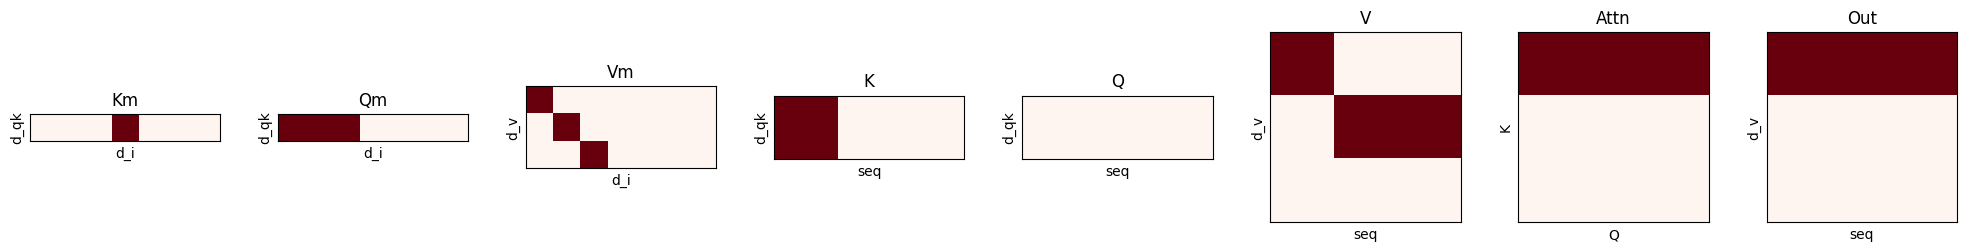

========================================    Learned    ========================================


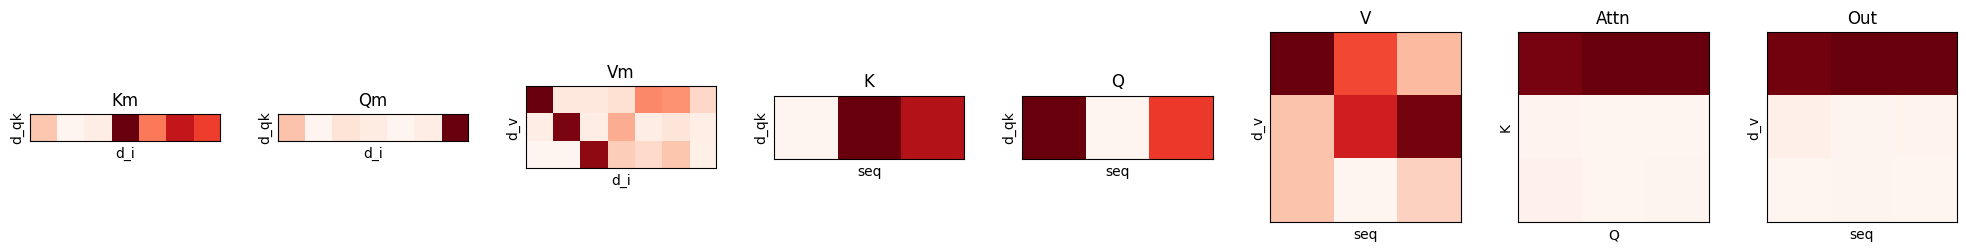

seq: [[1 0 0]
 [0 1 0]
 [0 1 0]]
Out (Hand designed) 
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
 Out (Learned) 
 [[ 0.98  0.03 -0.01]
 [ 1.01 -0.   -0.  ]
 [ 1.    0.01 -0.  ]]


In [8]:
# Compare the numpy and trained pytorch transformers
def make_batch_first(tokens=tokens, max_len=5):
    seq, target = generate_test_cases_first(tokens, max_len=max_len)
    return torch.FloatTensor(seq), torch.FloatTensor(target)

pos_dim = pos.shape[1]
transformer_py, loss = train_loop(make_batch_first, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1], pos_dim=pos_dim, max_seq_len=pos.shape[0])
seq = np.stack([A, B, B])
out_np, out_py = compare_transformers(np_transformer, transformer_py, seq)
print("seq:", seq)
print(f'Out (Hand designed) \n {np.round(out_np, 2)}')
print(f' Out (Learned) \n {np.round(out_py, 2)}')

In [9]:
for name,param in transformer_py.named_parameters():
  print(name,'\t\t', param)

pos.weight 		 Parameter containing:
tensor([[-0.3018,  0.3546, -0.2291, -1.3487],
        [ 1.5629,  3.2857, -0.3900, -0.5710],
        [ 1.1703,  0.0107,  1.1026, -0.6875],
        [ 0.2643,  0.1790,  2.0046, -0.6977]], requires_grad=True)
Qm.weight 		 Parameter containing:
tensor([[-0.1161, -0.4660, -0.3040, -0.3764, -0.4604, -0.3885,  1.0815]],
       requires_grad=True)
Km.weight 		 Parameter containing:
tensor([[ 0.0752, -0.1748, -0.1227,  0.9999,  0.3535,  0.7380,  0.5512]],
       requires_grad=True)
Vm.weight 		 Parameter containing:
tensor([[ 0.8890, -0.1185, -0.1196, -0.0768,  0.2344,  0.1987, -0.0414],
        [-0.1591,  0.8460, -0.1584,  0.1123, -0.1535, -0.1090, -0.1634],
        [-0.2091, -0.2071,  0.7986, -0.0020, -0.0491,  0.0302, -0.1704]],
       requires_grad=True)


### Question

In the figure provided, compare the variables of your hand-designed Transformer with those of the learned Transformer. **Identify the similarities and differences between the two sets of variables and provide a brief explanation for each.**

## Generate the Submission Log

Please download `submission_log.json` and submit it to Gradescope.

In [10]:
with open("submission_log.json", "w", encoding="utf-8") as f:
    json.dump(TO_SAVE, f)

## (Optional) Self-Attention: Attention by Content and Positoin

Finally, we'll explore how transformers can attend to tokens by looking at both their position and their content. In this section, we'll design a transformer for the following task: given a sequence of tokens, output a positive number for every unique token and a negative number for every repeated token.

To make implementing this easier, we'll add a CLS token to the beginning of the sequence. We will ignore the output of the CLS token index, which means we can use the CLS token to represent whatever we want. (In practice, the CLS token is often thought of as a representation of the entire sequence, but you can use it however is useful.)


\# Example data points (in each case, A, B, and C are vectors. A:pos_0 represents concatenation between vectors A and pos_0. The target outputs shown are +/-1, but any number with the right sign is fine. "Ignore" means that the output can be anything and will not be used to compute the loss.): \
Input sequence --> Input sequence with CLS and pos encoding --> Output sequence \
[A, B, C, C] --> [CLS: pos_0, A:pos_1, B:pos_2, C:pos_3, C:pos_4] --> [Ignore, 1, 1, -1, -1] \
[C, A, C] --> [CLS: pos_0, C:pos_1, A:pos_2, C:pos_3] --> [Ignore, -1, 1, 1] \
[B, B, C] --> [CLS: pos_0, B:pos_1, B:pos_2, C:pos_3] --> [Ignore, -1, -1, 1]


Once the test cases pass, run the training loop below a few times to train the PyTorch model. Comment on the similarities and differences between the weights and intermediate outputs of the learned and hand-coded model.

In [ ]:
A = np.array([1,0,0,0])
B = np.array([0,1,0,0])
C = np.array([0,0,1,0])
CLS = np.array([0,0,0,1])

tokens = [A, B, C]

In [ ]:
# Hints (feel free to ignore this block if it's not useful)

# Hint 1: All hints from the previous part still apply.

# Hint 2: To check if an array is unique, use what you discovered in the "select by content" part to find rows with the same value and
# what you learned in the "select by position" part to NOT select the key which comes from the same position as the query.

# Hint 3: If you need an offset value, consider using the CLS token The CLS token is the first token in a sequence, and it is orthogonal
# to all other tokens. This means you can create a query or value which selects it but not any othe token (e.g. by putting 0s in all
# indexes except the index where only CLS has a 1).

# Hint 4: You can use the following helper functions to test what keys, queries, and values would be produced by your matrix.
# You will need to provide a sequence (e.g. np.stack([A, B, C])). Km, Qm, Vm, and pos are the matrices you will define below.
get_K = lambda seq: np.concatenate([np.stack([CLS] + list(seq)), pos[:seq.shape[0]+1]], axis=1) @ Km # Each row of the output is a key
get_Q = lambda seq: np.concatenate([np.stack([CLS] + list(seq)), pos[:seq.shape[0]+1]], axis=1) @ Qm # Each row of the output is a query
get_V = lambda seq: np.concatenate([np.stack([CLS] + list(seq)), pos[:seq.shape[0]+1]], axis=1) @ Vm # Each row of the output is a value


In [ ]:

################################################################################################
# TODO: Implement numpy arrays for Km, Qm, and Vm and pos.
#      The dimensions of Km, and Qm are (input_dim + pos_dim, qk_dim).
#      The dimensions of Vm are (input_dim + pos_dim, v_dim).
#      The dimensions of pos are (max_len + 1, pos_dim). (Each row is a position vector.)
#      In this case, input_dim = 4, and v_dim = 1. qk_dim can be any value you choose, but 8 is
#      a reasonable choice. max_len is the maximum sequence length you will encounter (before CLS is added),
#      4 in this case.  pos_dim can be any value you choose, but 4 is a reasonable choice.
#################################################################################################

pos = NotImplementedError()

Km = NotImplementedError()

Qm = NotImplementedError()

Vm = NotImplementedError()

############################################ END OF YOUR CODE ####################################

def generate_test_cases_unique(tokens, max_len=5):
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    # Expected output is 1 for unique, -1 for non-unique
    expected_out = np.stack([1 if np.sum(np.min(input_arr == x, axis=1)) == 1 else -1 for x in input_arr]).reshape(-1, 1)
    # Insert CLS token as the first token in the sequence
    input_arr = np.stack([CLS] + list(input_arr))
    return input_arr, expected_out

seq, expected_out = generate_test_cases_unique([A, B, C])

for i in range(1):
    seq, expected_out = generate_test_cases_unique([A, B, C])
    np_transformer = NumpyTransformer(Km, Qm, Vm, pos)
    out = np_transformer.forward(seq, verbose=False)  # Change this to True to see the attention computation
    if not np.allclose(np.sign(out[1:]), expected_out, rtol=1e-3):
        print(f'FAIL: {seq} -> {np.sign(out[1:])} != {expected_out}')


In [ ]:
# Compare the numpy and trained pytorch transformers
# Note that the pytorch transformer has a slightly harder task since it is being trained to output exactly 1 or -1, not just the sign.
def make_batch_unique(tokens=tokens, max_len=5):
    seq, target = generate_test_cases_unique(tokens, max_len=max_len)
    return torch.FloatTensor(seq), torch.FloatTensor(target)

pos_dim = pos.shape[1]
transformer_py, loss = train_loop(make_batch_unique, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1], pos_dim=pos_dim, max_seq_len=pos.shape[0], remove_cls=True)
seq = np.stack([CLS, A, B, C, C])
expected_out = np.stack([1, 1, -1, -1]).reshape(-1, 1)
out_npy, out_pyt = compare_transformers(np_transformer, transformer_py, seq)
out_npy = np.sign(out_npy[1:])
out_pyt = np.sign(out_pyt[1:])

# Since the CLS token is visualized above and is not part of the sequence, we remove it here.
# We also take the sign of the output to directly compare it to the expected output.
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(out_npy.T, vmin=-1, vmax=1)
plt.title('Hand-Designed Transformer')
plt.xticks([])
plt.yticks([])
plt.xlabel('Sequence')
plt.ylabel('Output')
plt.subplot(1, 3, 2)
plt.imshow(out_pyt.T, vmin=-1, vmax=1)
plt.title('Trained Transformer')
plt.xticks([])
plt.yticks([])
plt.xlabel('Sequence')
plt.ylabel('Output')
plt.subplot(1, 3, 3)
plt.imshow(expected_out.T, vmin=-1, vmax=1)
plt.title('Expected Output')
plt.xticks([])
plt.yticks([])
plt.xlabel('Sequence')
plt.ylabel('Output')
plt.show()
